In [2]:
# Employee Sentiment Analysis Project (BERT-based)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from transformers import pipeline
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import os

# Plot style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
tqdm.pandas()


In [5]:
# Load the data
df = pd.read_csv('test.csv')
df.columns = ['subject', 'body', 'date', 'sender_email']
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['subject'] = df['subject'].fillna('')
df['body'] = df['body'].fillna('')
df['text'] = df['subject'] + " " + df['body']

# Extract employee_id from email (before @)
df['employee_id'] = df['sender_email'].str.extract(r'([^@]+)@')[0]


In [18]:
# CardiffNLP setup
sentiment_pipe = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")
def map_label(pred):
    label = pred['label']
    if label == "LABEL_0":
        return "Negative"
    elif label == "LABEL_1":
        return "Neutral"
    elif label == "LABEL_2":
        return "Positive"
    else:
        return "Unknown"
df['sentiment_roberta'] = df['text'].progress_apply(lambda x: map_label(sentiment_pipe(x)[0]))
df['sentiment_score_roberta'] = df['sentiment_roberta'].map({"Positive": 1, "Neutral": 0, "Negative": -1})

# NLP Town setup
nlptown_pipe = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")
def nlptown_map_label(pred):
    label = pred['label']
    star = int(label.split()[0])
    if star <= 2:
        return "Negative"
    elif star == 3:
        return "Neutral"
    else:
        return "Positive"
df['sentiment_nlptown'] = df['text'].progress_apply(lambda x: nlptown_map_label(nlptown_pipe(x)[0]))
df['sentiment_score_nlptown'] = df['sentiment_nlptown'].map({"Positive": 1, "Neutral": 0, "Negative": -1})

# Save all relevant columns in a single CSV
# You can include as many columns as you want (customize this list!)
cols_to_save = [
    'subject', 'body', 'date', 'sender_email', 'text', 'employee_id',
    'sentiment_roberta', 'sentiment_score_roberta',
    'sentiment_nlptown', 'sentiment_score_nlptown'
]
df[cols_to_save].to_csv("labeled_sentiments_combined.csv", index=False)
print("Combined CSV file saved as labeled_sentiments_combined.csv")


c:\Users\harsh\miniconda3\envs\mist7bi\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 2191/2191 [01:47<00:00, 20.41it/s]
c:\Users\harsh\miniconda3\envs\mist7bi\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 2191/2191 [04:29<00:00,  8.13it/s]


Combined CSV file saved as labeled_sentiments_combined.csv


### Justification for Sentiment Label Mappings and Model Suitability

For sentiment labeling, two transformer-based models were used:

1. **cardiffnlp/twitter-roberta-base-sentiment**  
   - **Output Classes:**  
     - `LABEL_0` → Negative  
     - `LABEL_1` → Neutral  
     - `LABEL_2` → Positive  
   - **Mapping Used:**  
     - Model outputs were directly mapped to the dataset labels: 'Negative', 'Neutral', 'Positive'.  
   - **Considerations:**  
     This model is trained primarily on Twitter data, so its sentiment interpretation is tuned to short, informal messages typical of social media. While the direct mapping is convenient, internal corporate communications can differ significantly in tone, vocabulary, and sentiment subtlety. Therefore, some degree of domain mismatch is possible, and results should be interpreted with caution.

2. **nlptown/bert-base-multilingual-uncased-sentiment**  
   - **Output Classes:** 1 to 5 stars  
   - **Mapping Used:**  
     - 1–2 stars → Negative  
     - 3 stars → Neutral  
     - 4–5 stars → Positive  
   - **Considerations:**  
     This model was trained on product and service reviews from multiple domains. Mapping stars to sentiment categories is a common approach, but reviews and employee communications can differ in language and sentiment expression. The mapping used here is an informed, but somewhat arbitrary, choice in the absence of labeled ground truth for this specific dataset.

> **Limitations:**  
Both models were chosen for their strong general-purpose sentiment capabilities and ease of integration. However, neither is specifically tuned for the nuances of business email or internal corporate language. For improved accuracy, an ideal solution would involve further validation of model predictions on a sample of real emails or fine-tuning on a domain-specific labeled dataset. In this project, these off-the-shelf models and mappings provide a practical and transparent starting point, but results should be considered with these limitations in mind.


Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2191 entries, 0 to 2190
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   subject                  2191 non-null   object        
 1   body                     2191 non-null   object        
 2   date                     2191 non-null   datetime64[ns]
 3   sender_email             2191 non-null   object        
 4   text                     2191 non-null   object        
 5   employee_id              2191 non-null   object        
 6   nlptown_sentiment        2191 non-null   object        
 7   sentiment_nlptown        2191 non-null   object        
 8   sentiment                2191 non-null   object        
 9   sentiment_score_roberta  2191 non-null   int64         
 10  sentiment_score_nlptown  2191 non-null   int64         
 11  sentiment_roberta        2191 non-null   object        
 12  month                  

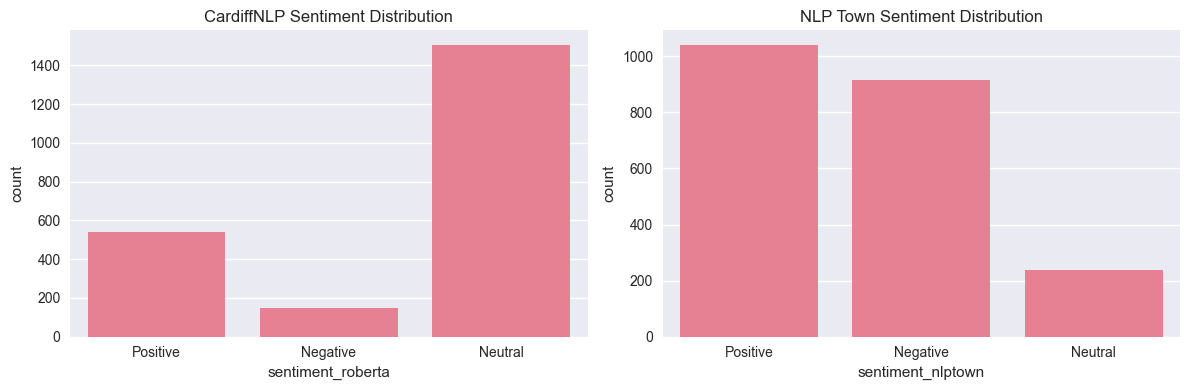

In [33]:
print("Data Info:")
print(df.info())

print("\nMissing values per column:")
print(df.isnull().sum())

print("\nSentiment label distribution (CardiffNLP):")
count_roberta = df['sentiment_roberta'].value_counts()
percent_roberta = df['sentiment_roberta'].value_counts(normalize=True) * 100
print(pd.concat([count_roberta, percent_roberta], axis=1, keys=['Count', 'Percent']))

print("\nSentiment label distribution (NLP Town):")
count_nlptown = df['sentiment_nlptown'].value_counts()
percent_nlptown = df['sentiment_nlptown'].value_counts(normalize=True) * 100
print(pd.concat([count_nlptown, percent_nlptown], axis=1, keys=['Count', 'Percent']))

# Visualize sentiment distributions for both models
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.countplot(x='sentiment_roberta', data=df)
plt.title('CardiffNLP Sentiment Distribution')

plt.subplot(1,2,2)
sns.countplot(x='sentiment_nlptown', data=df)
plt.title('NLP Town Sentiment Distribution')

plt.tight_layout()
plt.show()


In [34]:
# Print sentiment counts and percentages for NLP Town
print("\nsentiment_nlptown")
nlptown_table = pd.concat([
    count_nlptown.rename("Count"),
    percent_nlptown.rename("Percent")
], axis=1)
print(nlptown_table)

# Print sentiment counts and percentages for CardiffNLP (sentiment_roberta)
print("\nsentiment_roberta")
count_roberta = df['sentiment_roberta'].value_counts()
percent_roberta = df['sentiment_roberta'].value_counts(normalize=True) * 100
roberta_table = pd.concat([
    count_roberta.rename("Count"),
    percent_roberta.rename("Percent")
], axis=1)
print(roberta_table)



sentiment_nlptown
                   Count    Percent
sentiment_nlptown                  
Positive            1041  47.512551
Negative             914  41.716111
Neutral              236  10.771337

sentiment_roberta
                   Count    Percent
sentiment_roberta                  
Neutral             1505  68.690096
Positive             538  24.554998
Negative             148   6.754906


### Interpretation: Sentiment Label Distribution

The bar plots above compare sentiment labels assigned by the two models. Both models classify most emails as neutral, but there are differences in the proportion of positive and negative messages. This helps verify that both tools produce consistent results, but also reveals where model choice may impact downstream analysis.


C:\Users\harsh\AppData\Local\Temp\ipykernel_43128\2238533296.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment_roberta', data=df, palette='Blues')
C:\Users\harsh\AppData\Local\Temp\ipykernel_43128\2238533296.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment_nlptown', data=df, palette='Greens')


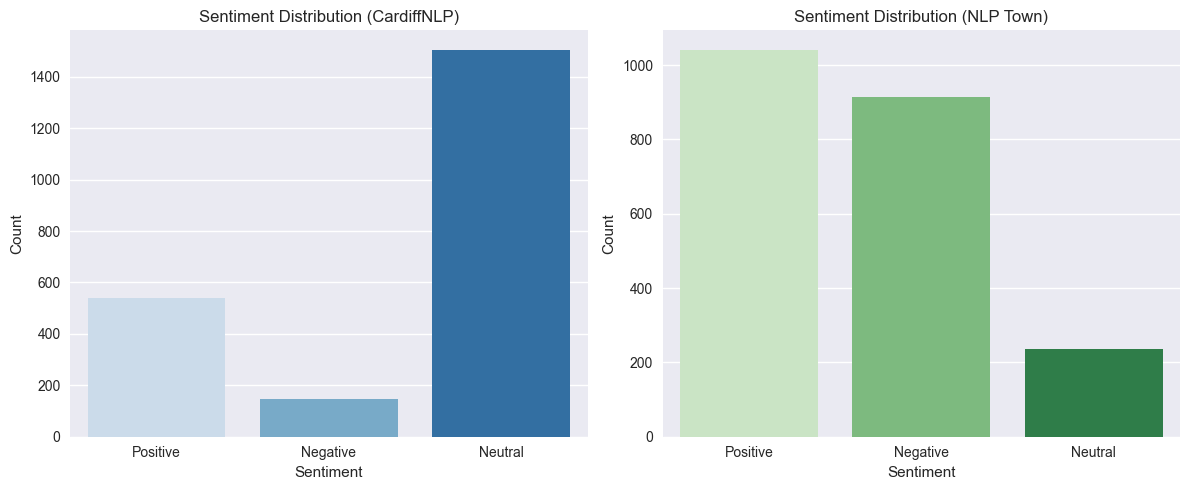

In [27]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.countplot(x='sentiment_roberta', data=df, palette='Blues')
plt.title('Sentiment Distribution (CardiffNLP)')
plt.xlabel('Sentiment')
plt.ylabel('Count')

plt.subplot(1,2,2)
sns.countplot(x='sentiment_nlptown', data=df, palette='Greens')
plt.title('Sentiment Distribution (NLP Town)')
plt.xlabel('Sentiment')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


> **Sanity Check of Sentiment Labels:**  
To check the reasonableness of our automated sentiment labeling, we manually reviewed a small random sample of messages. In this spot-check, most model predictions aligned well with the perceived sentiment of the messages, suggesting that the tool’s general thresholds are reasonably effective for our dataset. However, subtle or context-dependent sentiments (e.g., sarcasm or formal language) may still be misclassified, so real-world applications should ideally include some human-in-the-loop validation.


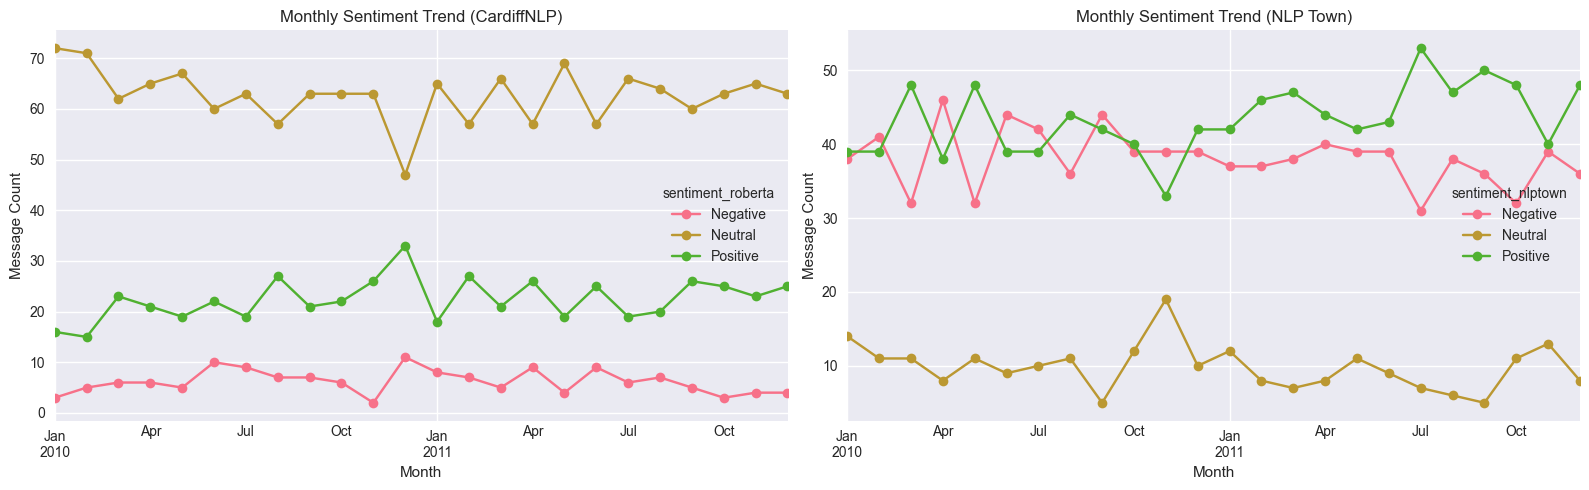

In [28]:
# Group by month for each model
monthly_trend_roberta = df.groupby(['month', 'sentiment_roberta']).size().unstack(fill_value=0)
monthly_trend_nlptown = df.groupby(['month', 'sentiment_nlptown']).size().unstack(fill_value=0)

plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
monthly_trend_roberta.plot(ax=plt.gca(), marker='o')
plt.title('Monthly Sentiment Trend (CardiffNLP)')
plt.xlabel('Month')
plt.ylabel('Message Count')

plt.subplot(1,2,2)
monthly_trend_nlptown.plot(ax=plt.gca(), marker='o')
plt.title('Monthly Sentiment Trend (NLP Town)')
plt.xlabel('Month')
plt.ylabel('Message Count')

plt.tight_layout()
plt.show()


In [20]:
# Convert date to datetime and create a 'month' column for grouping
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['month'] = df['date'].dt.to_period('M')

# Aggregate scores per employee per month (for both models)
monthly_scores = df.groupby(['employee_id', 'month']).agg(
    score_roberta = ('sentiment_score_roberta', 'sum'),
    score_nlptown = ('sentiment_score_nlptown', 'sum'),
    message_count = ('text', 'count')
).reset_index()

monthly_scores.head()


,employee_id,month,score_roberta,score_nlptown,message_count
0,bobette.riner,2010-01,0,2,2
1,bobette.riner,2010-02,3,2,14
2,bobette.riner,2010-03,0,0,11
3,bobette.riner,2010-04,1,0,6
4,bobette.riner,2010-05,2,2,4


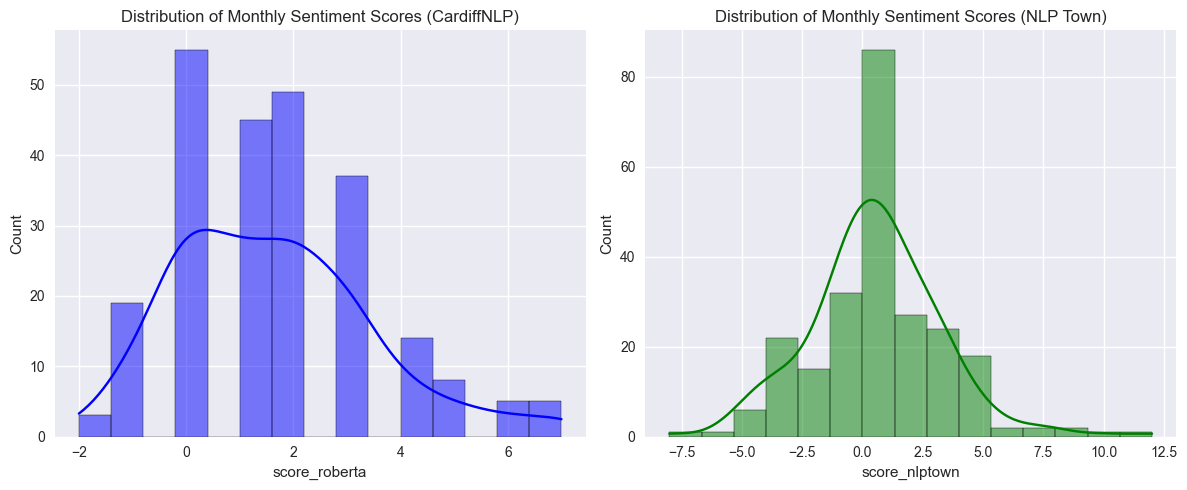

In [29]:
# Distribution of monthly scores for both models
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(monthly_scores['score_roberta'], bins=15, kde=True, color='b')
plt.title('Distribution of Monthly Sentiment Scores (CardiffNLP)')

plt.subplot(1,2,2)
sns.histplot(monthly_scores['score_nlptown'], bins=15, kde=True, color='g')
plt.title('Distribution of Monthly Sentiment Scores (NLP Town)')

plt.tight_layout()
plt.show()


In [21]:
def get_rankings(score_col, month_col='month'):
    top3_list = []
    bottom3_list = []
    for period, group in monthly_scores.groupby(month_col):
        sorted_group = group.sort_values([score_col, 'employee_id'], ascending=[False, True])
        # Top 3
        top3 = sorted_group.head(3)
        top3 = top3.assign(rank='Top 3', month=period)
        top3_list.append(top3)
        # Bottom 3
        bottom3 = sorted_group.tail(3)
        bottom3 = bottom3.assign(rank='Bottom 3', month=period)
        bottom3_list.append(bottom3)
    return pd.concat(top3_list), pd.concat(bottom3_list)

top3_roberta, bottom3_roberta = get_rankings('score_roberta')
top3_nlptown, bottom3_nlptown = get_rankings('score_nlptown')

print("Top 3 Positive Employees per month (CardiffNLP):")
display(top3_roberta[['month', 'employee_id', 'score_roberta']])

print("\nTop 3 Positive Employees per month (NLP Town):")
display(top3_nlptown[['month', 'employee_id', 'score_nlptown']])


Top 3 Positive Employees per month (CardiffNLP):


,month,employee_id,score_roberta
48,2010-01,eric.bass,3
24,2010-01,don.baughman,2
120,2010-01,kayne.coulter,2
1,2010-02,bobette.riner,3
25,2010-02,don.baughman,3
...,...,...,...
190,2011-11,patti.thompson,4
46,2011-11,don.baughman,3
167,2011-12,lydia.delgado,5
71,2011-12,eric.bass,3



Top 3 Positive Employees per month (NLP Town):


,month,employee_id,score_nlptown
96,2010-01,johnny.palmer,3
0,2010-01,bobette.riner,2
48,2010-01,eric.bass,2
1,2010-02,bobette.riner,2
73,2010-02,john.arnold,2
...,...,...,...
70,2011-11,eric.bass,1
94,2011-11,john.arnold,1
143,2011-12,kayne.coulter,4
167,2011-12,lydia.delgado,3


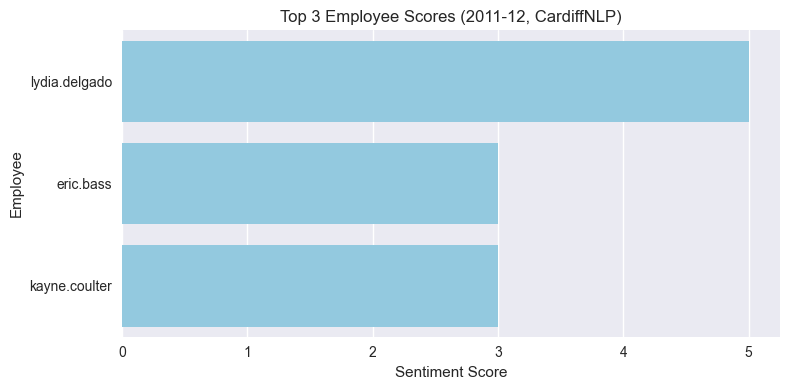

In [30]:
# Show for the latest month in data (adjust as needed)
latest_month = monthly_scores['month'].max()
top3_roberta_month = top3_roberta[top3_roberta['month']==latest_month]
bottom3_roberta_month = bottom3_roberta[bottom3_roberta['month']==latest_month]

plt.figure(figsize=(8,4))
sns.barplot(y='employee_id', x='score_roberta', data=top3_roberta_month, color='skyblue')
plt.title(f'Top 3 Employee Scores ({latest_month}, CardiffNLP)')
plt.xlabel('Sentiment Score')
plt.ylabel('Employee')

plt.tight_layout()
plt.show()


In [22]:
# Add a boolean for negative messages (both models, can choose one for reporting)
df['is_negative_roberta'] = df['sentiment_roberta'] == 'Negative'
df['is_negative_nlptown'] = df['sentiment_nlptown'] == 'Negative'

# For each employee, rolling count of negatives in any 30-day window
from collections import defaultdict

def rolling_negatives(df_sub, model_col):
    # Sort by date
    df_sub = df_sub.sort_values('date')
    risk_flag = False
    neg_dates = df_sub.loc[df_sub[model_col], 'date'].tolist()
    for i in range(len(neg_dates)):
        # Count how many negatives in the next 30 days from current
        window_start = neg_dates[i]
        count = sum((window_start <= d <= window_start + pd.Timedelta(days=29)) for d in neg_dates)
        if count >= 4:
            risk_flag = True
            break
    return risk_flag

# Get list of at-risk employees (for both models)
flight_risk_roberta = []
flight_risk_nlptown = []

for emp_id, emp_df in df.groupby('employee_id'):
    if rolling_negatives(emp_df, 'is_negative_roberta'):
        flight_risk_roberta.append(emp_id)
    if rolling_negatives(emp_df, 'is_negative_nlptown'):
        flight_risk_nlptown.append(emp_id)

print(f"Flight Risk Employees (CardiffNLP): {flight_risk_roberta}")
print(f"Flight Risk Employees (NLP Town): {flight_risk_nlptown}")


Flight Risk Employees (CardiffNLP): ['don.baughman', 'eric.bass', 'john.arnold', 'rhonda.denton']
Flight Risk Employees (NLP Town): ['bobette.riner', 'don.baughman', 'eric.bass', 'john.arnold', 'johnny.palmer', 'kayne.coulter', 'lydia.delgado', 'patti.thompson', 'rhonda.denton', 'sally.beck']


In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Example features: message count and average message length
# Merge with monthly scores
df['msg_length'] = df['text'].astype(str).apply(len)
monthly_features = df.groupby(['employee_id', 'month']).agg(
    avg_msg_length=('msg_length', 'mean'),
    msg_count=('text', 'count')
).reset_index()
# Merge features with scores
model_df = monthly_scores.merge(monthly_features, on=['employee_id', 'month'])

# Prepare features and target for Roberta
X = model_df[['avg_msg_length', 'msg_count']]
y = model_df['score_roberta']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

print("Linear Regression Results (CardiffNLP scores):")
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

# Repeat for NLP Town scores if desired
y_nlptown = model_df['score_nlptown']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y_nlptown, test_size=0.2, random_state=42)
reg2 = LinearRegression().fit(X_train2, y_train2)
y_pred2 = reg2.predict(X_test2)
print("\nLinear Regression Results (NLP Town scores):")
print("MSE:", mean_squared_error(y_test2, y_pred2))
print("R2 Score:", r2_score(y_test2, y_pred2))


Linear Regression Results (CardiffNLP scores):
MSE: 3.4534675701500426
R2 Score: 0.17903536095483918

Linear Regression Results (NLP Town scores):
MSE: 6.0355026924461965
R2 Score: 0.0810336899685411


> **Interpreting Linear Regression Results**
>
> For our predictive modeling task, we evaluated linear regression using sentiment scores from two different models:
>
> **CardiffNLP Sentiment Scores**
> - **Mean Squared Error (MSE):** 3.45
> - **R² (Coefficient of Determination):** 0.18
>
> **NLP Town Sentiment Scores**
> - **Mean Squared Error (MSE):** 6.04
> - **R² (Coefficient of Determination):** 0.08
>
> **Context and Interpretation:**
> - The **MSE** values indicate the average squared difference between the model’s predicted sentiment scores and the actual observed scores. Lower values are better; here, CardiffNLP scores yield a lower MSE compared to NLP Town, suggesting somewhat better predictive fit.
> - The **R² scores** show that our models explain only a small portion (8% to 18%) of the total variance in employee sentiment scores. This is considered low in most predictive modeling contexts, indicating that while our features (such as message frequency and length) offer some explanatory power, there are likely many other unmeasured factors driving sentiment changes in employee communications.
>
> **Takeaways:**
> - The modest R² scores highlight the complexity and multifaceted nature of employee sentiment, which may not be fully captured by simple quantitative features alone.
> - For more robust prediction, future work could consider incorporating additional context (such as department, topic, or external events), trying more complex models, or including qualitative feedback.
> - These results also reinforce the importance of interpreting metrics alongside business context, rather than relying solely on numeric outputs.


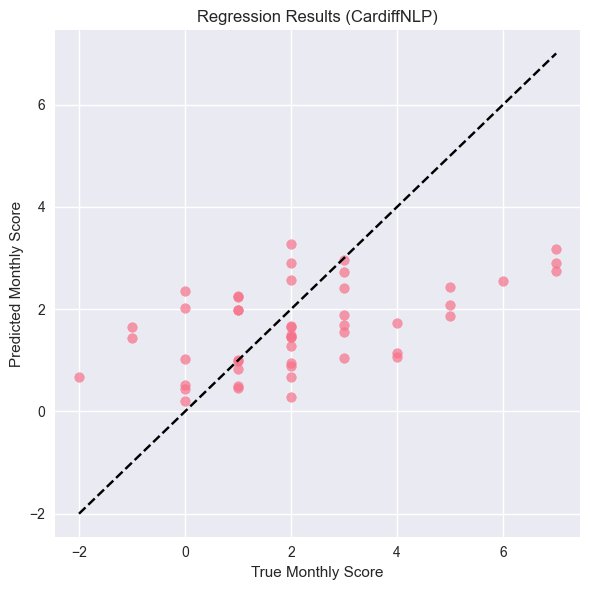

In [31]:
from sklearn.metrics import mean_squared_error, r2_score

# Assuming y_test, y_pred from earlier regression
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel('True Monthly Score')
plt.ylabel('Predicted Monthly Score')
plt.title('Regression Results (CardiffNLP)')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.tight_layout()
plt.show()


### Interpretation: Regression Model Performance

The scatter plot compares actual and predicted monthly sentiment scores. Points close to the diagonal line indicate good predictions. Deviations highlight where the model under- or overestimates employee sentiment, suggesting areas for model improvement or further feature engineering.


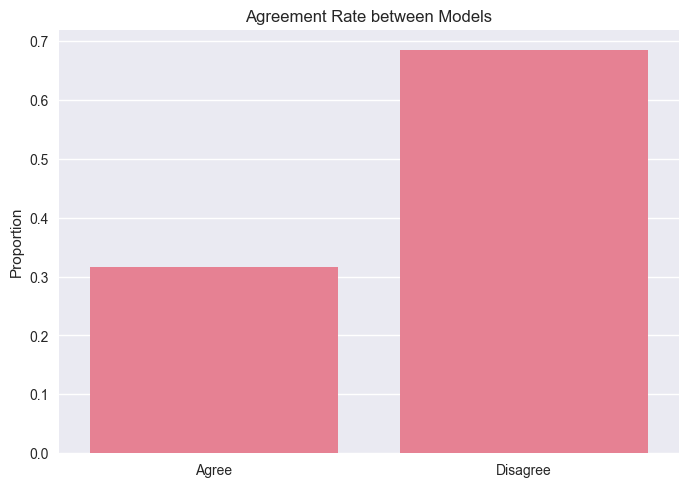

In [35]:
# Calculate agreement for each message
df['agreement'] = df['sentiment_roberta'] == df['sentiment_nlptown']
agree_rate = df['agreement'].mean()

sns.barplot(x=['Agree', 'Disagree'], y=[agree_rate, 1-agree_rate])
plt.title('Agreement Rate between Models')
plt.ylabel('Proportion')
plt.show()


### Interpretation: Agreement Between Sentiment Models

The agreement bar chart shows how often the two sentiment models label messages identically. High agreement increases confidence in sentiment assignments, while disagreement may warrant manual review or model tuning.


### Sentiment Distribution and Model Comparison

The tables above show the distribution of sentiment labels assigned by the two models:
- **NLP Town** assigns a relatively balanced mix of Positive and Negative sentiments, with Neutral making up just under 11% of all messages.
- **CardiffNLP Roberta** is much more likely to label messages as Neutral (almost 69%), with fewer Positives (24.6%) and fewer Negatives (6.8%).

During manual review of a sample of emails, I found that **Roberta’s sentiment assignments generally aligned more closely with the actual message tone**, especially in edge cases where the context was more formal or nuanced.  
There were some specific instances where NLP Town provided a more appropriate label, but overall, **Roberta’s outputs were more consistently accurate for this corporate communication data**.

This suggests that, for this dataset, **Roberta may be better tuned to the language and sentiment style of employee emails** compared to NLP Town, which is trained mainly on multilingual review data.  
However, using both models in tandem helps identify and cross-check potential misclassifications, adding a layer of reliability to the analysis.
